In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifelines as lfl

In [5]:
colon = pd.read_csv('colon.csv')

In [6]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=colon['time'], event_observed=colon['status'])

# Raw event table
event_table = kmf.event_table.reset_index().rename(
    columns={'event_at': 'time',
             'removed': 'at_risk',
             'observed': 'events',
             'censored': 'censored'}
)
print(event_table.head(10))


   time  at_risk  events  censored  entrance  at_risk
0   0.0        0       0         0       888      888
1   8.0        1       1         0         0      888
2   9.0        1       1         0         0      887
3  19.0        1       1         0         0      886
4  20.0        1       1         0         0      885
5  23.0        1       0         1         0      884
6  24.0        1       0         1         0      883
7  28.0        1       1         0         0      882
8  35.0        1       1         0         0      881
9  36.0        1       1         0         0      880


In [11]:

T = colon['time']
E = colon['status']

# 2. Define fixed intervals, e.g. 0–30, 30–60, … up to max time
max_time = int(T.max())
interval_width = 30
breaks = np.arange(0, max_time + interval_width, interval_width)

# 3. Build the life table
rows = []
for start, stop in zip(breaks[:-1], breaks[1:]):
    # people who enter the interval
    at_risk = ((T >= start) & (T < stop)).sum() + (T >= stop).sum()
    # events in [start, stop)
    events = ((T >= start) & (T < stop) & (E == 1)).sum()
    # censored in [start, stop)
    censored = ((T >= start) & (T < stop) & (E == 0)).sum()
    rows.append({
        'interval_start': start,
        'interval_end': stop,
        'at_risk': at_risk,
        'events': events,
        'censored': censored
    })

life_table = pd.DataFrame(rows)
print(life_table)


     interval_start  interval_end  at_risk  events  censored
0                 0            30      888       5         2
1                30            60      881       8         2
2                60            90      871      18         0
3                90           120      853      24         0
4               120           150      829      14         0
..              ...           ...      ...     ...       ...
106            3180          3210        7       0         2
107            3210          3240        5       0         1
108            3240          3270        4       0         0
109            3270          3300        4       0         0
110            3300          3330        4       0         4

[111 rows x 5 columns]


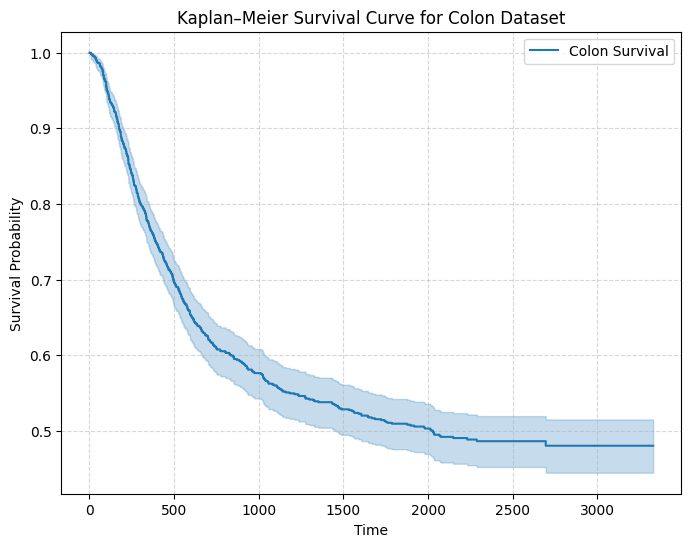

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, label='Colon Survival')

# 3. Plot survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function(ci_show=True)
plt.title('Kaplan–Meier Survival Curve for Colon Dataset')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# wybor zmiennych do modelu

from lifelines.statistics import logrank_test

colon['age_high'] = (colon['age'] > colon['age'].median()).astype(int)
ix_low  = colon['age_high'] == 0
ix_high = colon['age_high'] == 1

results = logrank_test(
    colon.loc[ix_low,  'time'], 
    colon.loc[ix_high, 'time'],
    event_observed_A=colon.loc[ix_low,  'status'],
    event_observed_B=colon.loc[ix_high, 'status']
)
print(f"p‑value = {results.p_value:.4f}")
print(results.summary)


p‑value = 0.7837
   test_statistic         p  -log2(p)
0         0.07532  0.783743  0.351548


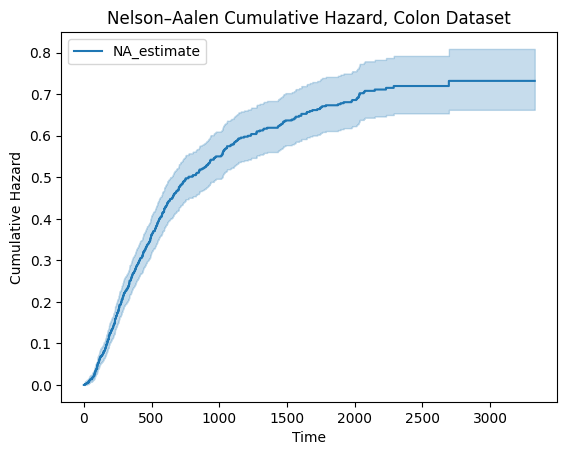

In [9]:
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt

naf = NelsonAalenFitter()
naf.fit(durations=colon['time'], event_observed=colon['status'])

# Plot cumulative hazard
naf.plot_cumulative_hazard()
plt.title("Nelson–Aalen Cumulative Hazard, Colon Dataset")
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.show()


In [16]:
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, GeneralizedGammaFitter, CoxPHFitter


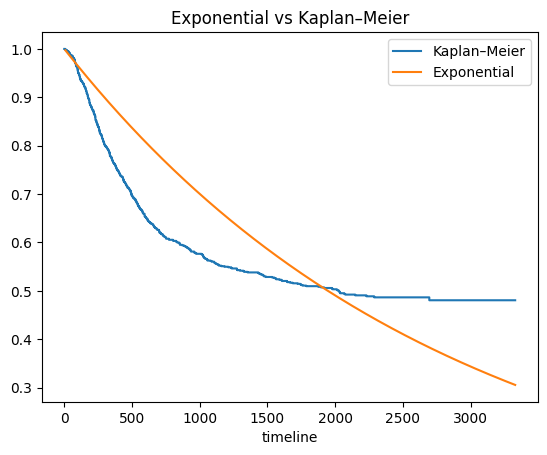

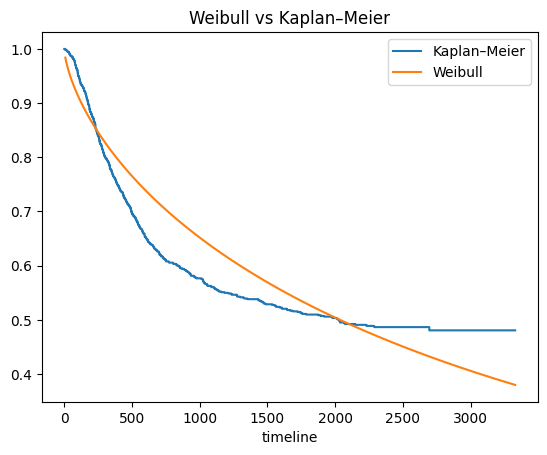

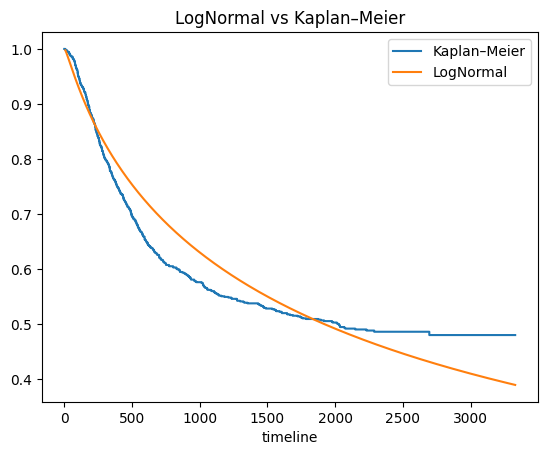

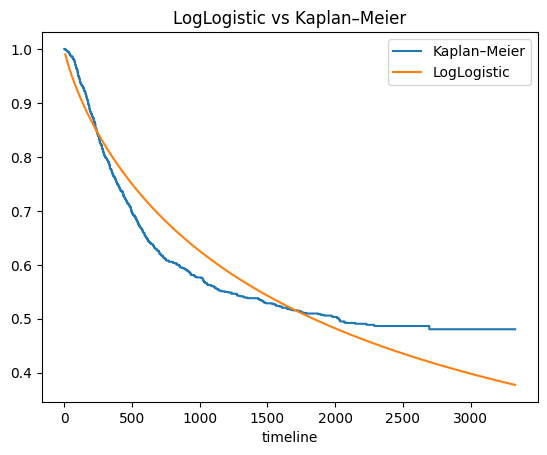

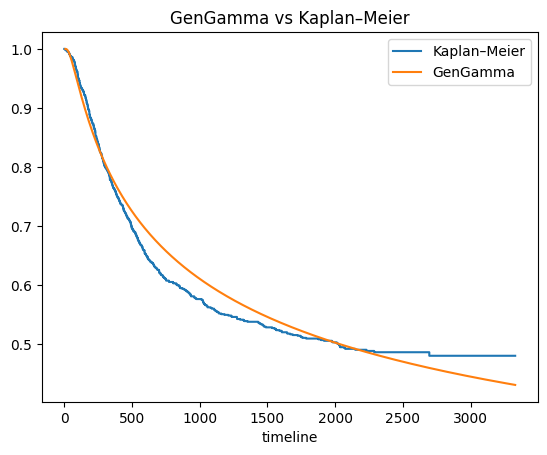


Exponential model summary:
                coef    se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  2808.062893  132.965637     2547.455034     3068.670753     0.0   

                 z             p    -log2(p)  
lambda_  21.118711  5.353560e-99  326.450383  
AIC: 7976.703109306974

Weibull model summary:
                coef    se(coef)  coef lower 95%  coef upper 95%  cmp to  \
lambda_  3492.484145  268.030588     2967.153845     4017.814444     1.0   
rho_        0.678398    0.028714        0.622119        0.734676     1.0   

                 z             p    -log2(p)  
lambda_  13.026439  8.655362e-39  126.441601  
rho_    -11.200214  4.067477e-29   94.311780  
AIC: 7880.279620928219

LogNormal model summary:
            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     7.562233  0.080746        7.403974        7.720492     0.0  93.654667   
sigma_  1.963160  0.074056        1.818013        2.108307     1.0  13.005852   

               

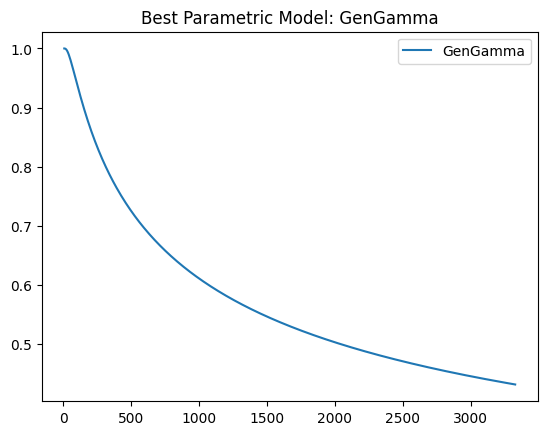

In [20]:
models = {
    'Exponential': ExponentialFitter(),
    'Weibull': WeibullFitter(),
    'LogNormal': LogNormalFitter(),
    'LogLogistic': LogLogisticFitter(),
    'GenGamma': GeneralizedGammaFitter()
}

# Fit models and collect AICs
aic_values = {}
for name, model in models.items():
    model.fit(colon['time'], colon['status'], label=name)
    aic_values[name] = model.AIC_

# Plot each model's survival function with Kaplan–Meier
for name, model in models.items():
    plt.figure()
    kmf.plot_survival_function(ci_show=False, label='Kaplan–Meier')
    model.plot_survival_function(ci_show=False, label=name)
    plt.title(f'{name} vs Kaplan–Meier')
    plt.legend()
    plt.show()

# Print model summaries and AICs
for name, model in models.items():
    print(f"\n{name} model summary:")
    print(model.summary)
    print(f"AIC: {model.AIC_}")

# Determine best model based on lowest AIC
best_model_name = min(aic_values, key=aic_values.get)
best_model = models[best_model_name]
print(f"\nBest model based on AIC: {best_model_name} (AIC={aic_values[best_model_name]})")

# Plot best model's survival function alone
plt.figure()
best_model.plot_survival_function(ci_show=False, label=best_model_name)
plt.title(f'Best Parametric Model: {best_model_name}')
plt.legend()
plt.show()

In [15]:
# 3. Semiparametric: Cox PH
cph = CoxPHFitter()
cph.fit(colon[['time','status','age','sex','rx']], 'time', 'status')
cph.check_assumptions(colon[['time','status','age','sex','rx']], p_value_threshold=0.05)

cph.print_summary()

Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 888 total observations, 442 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 888
number of events observed = 446
   partial log-likelihood = -2867.61
         time fit was run = 2025-05-10 19:23:53 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
sex       -0.13      0.88      0.09           -0.32            0.05                0.73                1.05
rx        -0.23      0.80      0.06           -0.34           -0.11                0.71                0.89

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.45   0.15      2.76
sex          0.00 -1.40   0.16      2.63
rx           0.00 -3.90 <0.005     13.34
---
Concordance = 0.56
Partial AIC = 5741.21
log-likelihood ratio test = 19.05 on 3 df
-log2(p) of ll-ratio test = 11.87